# Robust Journey Planner
This notebook describes the general path we have followed in order to convert raw data into a meaningful journey planner. The most important aspect of our developed planner is its robustness given that after exhaustive delay analysis based on historical data, every trip is associated with a probility. The system can be tested thanks to a validation method and the results can be visualied thanks to a curated interface. The purpose of this notebook is just to guide the reader in our learning and development process but there are links to more specific notebooks where all the details can be found. There are several parts to take into consideration:
*   **[Initial Setup](#initial)** — import libraries and explain tools that will be used
*   **[Public Transport Network](#network)**  — define network structure and connections timetable.
*   **[Probabilistic Model](#probability)** — analyse delay for associating every connection with an uncertainty rsk.
*   **[Route Planner Algorithm](#algorithm)**  — to apply a function to each element.
*   **[User Interface](#interface)** — design interface with desired trip as input and connection alternatives as output
*   **[Validation Method](#validation)** — test the developed system for checking its proper funtioning.

<a id = 'initial'></a>
## 1.Initial Setup

We use the following tools in order to clean, process, store, analyse and visualise the data:
*  PySpark : it allows us to perform actions and transformations on dataframes
*  HDFS:
*  Pandas:
*  Bokeh:


In [7]:
import pandas as pd
import numpy as np
import math

In [4]:
from hdfs3 import HDFileSystem
hdfs = HDFileSystem(host='hdfs://iccluster044.iccluster.epfl.ch', port=8020, user='ebouille')
def read_csv(path, parts=None, **kwargs):
    dfs = []
    file_paths = [file_path for file_path in hdfs.ls(path) if file_path.endswith('.csv')]
    if parts:
        file_paths = file_paths[:parts]
    for file_path in file_paths:
        with hdfs.open(file_path) as file:
            dfs.append(pd.read_csv(file, **kwargs))
    return pd.concat(dfs)


<a id = 'network'></a>
## 2. Public Transport Network


Our project is based on the data published on  [ Open Data Platform Mobility Switzerland](https://opentransportdata.swiss/en/) This platform provides with scheduled timetables and actual historical data of several public trasnport services in Switzerland. In this section, we explain which data is actually relevant for our purposes and how we can model the public transport system

### 2.1 Zurich stations

We will be focusing on **Zurich** region, so we only take into account transport stops that are within 15-km of Zurich, taking <code>Zurich HB = [8.540192,47.378177]</code>  as reference point. The stations data [BFKOORD_GEO](https://opentransportdata.swiss/en/cookbook/hafas-rohdaten-format-hrdf/#Abgrenzung) is stored under HDFS <code>/data/sbb/stations/bfkoordgeo.csv</code> where latitude, longitude and height of every station is listed. We will compute the **Haversine distance** between Zurich HB and the rest of the stations for filtering out those that are outside the **15 km radius**. Please refer to [get_stations](./get_stations.ipynb) for more details. As a result, we obtain the following dataframe:


In [11]:
stations_info = read_csv('../data/zurich_stations_info.csv', parts=1)
stations_info.head()

,StationID,Longitude,Latitude,Height,Remark,Distance_from_Zurich
0,65,8.595545,47.409209,430,"Wallisellen, Glatt",5409.956757
1,66,8.595545,47.409209,430,"Wallisellen, Zentrum Glatt",5409.956757
2,176,8.521961,47.351679,0,Zimmerberg-Basistunnel,3250.669989
3,8502186,8.398942,47.393407,428,Dietikon Stoffelbach,10768.073180
4,8502187,8.377032,47.364740,502,Rudolfstetten Hofacker,12377.426177


### 2.2 What is a connection?

So after definiing the static nodes of our network (Zurich stations), we have to add the edges (the links) between each of them. Can we go from all possible stations to the rest of all possible stations? Is it worth it? How can we go? They are rather difficult questions to ask at first hand but it becomes easier after we perform some exploratory analysis on [SBB historical data](https://opentransportdata.swiss/en/dataset/istdaten) and we understand the difference between trip and connection: a **trip** makes reference to an ordered sequence of stops but they appear in different rows (one stop each) (having both arrival and departure times to/from this specific stop), where as a **connection** involves the departure time from one stop and the arrival time to a different one. Therefore, we conclude that connections are the edges of our network we are looking for, although the dataset is expressed in trips.

### 2.3 Walking connections

We start by looking at the easier connections: the walking ones. We assume it is sensible to connect **nearby stations** (<500 m of distance) by walking and we compute the required transfer time between each pair of stations. For more details please refere to the last part of the notebook [get_stations](./get_stations.ipynb). As a result, we obtain the following dataframe:

In [12]:
walking_connections = read_csv("../data/zurich_walking_connections.csv", parts=1)
walking_connections.head()

,ID1,Lon1,Lat1,H1,ID2,Lon2,Lat2,H2,Distance (m),Speed (m/min),Transfer time (sec)
0,65,8.595545,47.409209,430,65,8.595545,47.409209,430,0.000000,50.00,120.0
1,65,8.595545,47.409209,430,66,8.595545,47.409209,430,0.000000,50.00,120.0
2,65,8.595545,47.409209,430,8503129,8.591911,47.412717,431,493.557390,49.99,712.0
3,65,8.595545,47.409209,430,8587651,8.595545,47.409209,430,0.000000,50.00,120.0
4,65,8.595545,47.409209,430,8587655,8.592534,47.412720,431,463.889894,49.99,677.0


### 2.4 Transport connections timetable

There is a specific column in SBB dataset which refers to the **type of transport** for each trip. The most frequent ones are Train (Zug), Bus and Tram, but as mentioned beforet they are expressed in terms of trips, not in terms of connections. Therefore we need to transform the dataset so that we can link the different nodes (stations) of our network. Nonetheless, it is not a good idea to use the SBB historical for this purpose, given that if we select a random day and extract the connections of that specific day, there might be some **actual data missing**.

Having said that, we decide to use the timetable files available under HDFS, specially <code>stop_times.txt</code>, and we **build a schedule** for an "ideal" working day between 5h and 21h. Our network is thereby completed with the nodes (stations) and the edges (connections). After transforming the trips to connections in the notebook [get_timetable](./get_timetable.ipynb), we obtain the following dataframe:

In [ ]:
#id_connections = spark.read.orc('/user/datavirus/id_connections.orc')

<a id = 'probability'></a>

## 3. Probabilistic Model

At the beggining of this lab course, we were confronted with the SBB dataset and we were able to analyse the delay distributions. As we can observe on the images (obtained from homework 1d), they have the shape of an exponential decay so we decided to base our predictive model on the expponential distribution. The corresponding probability desnity function is given (for$ x \geq 0 $) by:

$$ f(x;\lambda) = \lambda e^{-\lambda x} $$  

We see that the only paramater we have to determine is the *rate parameter* $\lambda$ which corresponds to the inverse of the mean delay. In other words, if we determine the mean delay of every possible connection, we will be able to build the predictive model

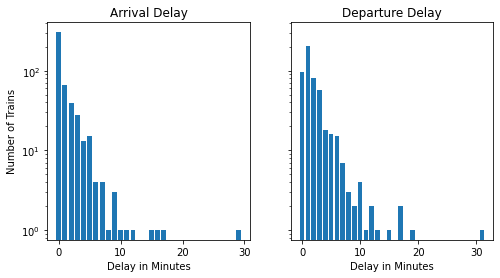

### 3.1 Delay analysis

Our objective is then to obtain the delay probability and the mean delay for every possible connection in our "ideal" schedule. However, it seems quite difficult to achieve given that it is very likely that there's missing data from many different connections. To overcome this problem, we have come up with a three-level probability strategy which allows us to select different delays probabilities for the same connections depending on the number of data points supporting it. For more details, please refer to [delay_analysis](./delay_analysis.ipynb)

In [ ]:
#probability = spark.read.orc('/user/datavirus/probability.orc')

### 3.2 Predictive model

Once we have used the SBB historical data to obtain as much information about the probability of delay for as many connections as possible, it is time to feed our public trasnport network with this delay data. We "simply" have to merge the "static" transport network with the delay probabilities into a single dataframe shown below. Please refer to [delay_prediction](./delay_prediction.ipynb)

In [14]:
connections = read_csv('/user/datavirus/connections.csv',parts=1)
connections.head()

,stop_sequence,route_type,start_id,start_time,trip_id,transport_type,line_text,stop_time,stop_id,delay_probability,delay_parameter
0,29,900,8591305,13:00:00,1155.TA.26-7-B-j19-1.6.R,tram,7,13:01:00,8591271,0.830450,0.014242
1,28,900,8530812,13:00:00,890.TA.26-11-A-j19-1.3.H,tram,11,13:01:00,8591180,0.851468,0.011924
2,27,900,8591245,12:59:00,1939.TA.26-13-j19-1.24.H,tram,13,13:01:00,8591405,0.847539,0.012390
3,27,900,8591427,12:59:00,3191.TA.26-9-B-j19-1.25.H,tram,9,13:01:00,8573710,0.848292,0.014791
4,27,700,8591197,13:00:00,268.TA.26-308-j19-1.12.R,bus,308,13:01:00,8591434,0.889047,0.012551


## 4. Route Planner Algorithm

<a id = 'algorithm'></a>

## 5. User Interface

<a id = 'interface'></a>

## 6. Validation method

<a id = 'validation'></a>